## 搭建一个简单的问答系统 （Building a Simple QA System）

本次项目的目标是搭建一个基于检索式的简易的问答系统，这是一个最经典的方法也是最有效的方法。  

#### 检索式的问答系统
问答系统所需要的数据已经提供，对于每一个问题都可以找得到相应的答案，所以可以理解为每一个样本数据是 ``<问题、答案>``。 那系统的核心是当用户输入一个问题的时候，首先要找到跟这个问题最相近的已经存储在库里的问题，然后直接返回相应的答案即可（但实际上也可以抽取其中的实体或者关键词)。 举一个简单的例子：

假设我们的库里面已有存在以下几个<问题,答案>：
- <"阿里巴巴主要做什么方面的业务？”， “他们主要做电商方面”>
- <"人工智能和机器学习的关系什么？", "其实机器学习是人工智能的一个范畴，很多人工智能的应用要基于机器学习的技术">
- <"人工智能最核心的语言是什么？"， ”Python“>
- .....

假设一个用户往系统中输入了问题 “alibaba是做什么的？”， 那这时候系统先去匹配最相近的“已经存在库里的”问题。 那在这里很显然是 “alibaba是做什么的”和“alibaba主要做什么方面的业务？”是最相近的。 所以当我们定位到这个问题之后，直接返回它的答案 “他们主要做人工智能方面的教育”就可以了。 所以这里的核心问题可以归结为计算两个问句（query）之间的相似度。

#### 项目中涉及到的任务描述
问答系统看似简单，但其中涉及到的内容比较多。 在这里先做一个简单的解释，总体来讲，我们即将要搭建的模块包括：

- 文本的读取： 需要从相应的文件里读取```(问题，答案)```
- 文本预处理： 清洗文本很重要，需要涉及到```停用词过滤```等工作
- 文本的表示： 如果表示一个句子是非常核心的问题，这里会涉及到```tf-idf```, ```Glove```以及```BERT Embedding```
- 文本相似度匹配： 在基于检索式系统中一个核心的部分是计算文本之间的```相似度```，从而选择相似度最高的问题然后返回这些问题的答案
- 倒排表： 为了加速搜索速度，我们需要设计```倒排表```来存储每一个词与出现的文本
- 词义匹配：直接使用倒排表会忽略到一些意思上相近但不完全一样的单词，我们需要做这部分的处理。我们需要提前构建好```相似的单词```然后搜索阶段使用
- 拼写纠错：我们不能保证用户输入的准确，所以第一步需要做用户输入检查，如果发现用户拼错了，我们需要及时在后台改正，然后按照修改后的在库里面搜索
- 文档的排序： 最后返回结果的排序根据文档之间```余弦相似度```有关，同时也跟倒排表中匹配的单词有关


#### 项目中需要的数据：
1. ```train-v2.0.json```: 这个数据包含了问题和答案的pair， 但是以JSON格式存在，需要编写parser来提取出里面的问题和答案。 
2. ```glove.6B```: 这个文件需要从网上下载，下载地址为：https://nlp.stanford.edu/projects/glove/， 请使用d=200的词向量
3. ```spell-errors.txt``` 这个文件主要用来编写拼写纠错模块。 文件中第一列为正确的单词，之后列出来的单词都是常见的错误写法。 但这里需要注意的一点是我们没有给出他们之间的概率，也就是p(错误|正确），所以我们可以认为每一种类型的错误都是```同等概率```
4. ```vocab.txt``` 这里列了几万个英文常见的单词，可以用这个词库来验证是否有些单词被拼错
5. ```testdata.txt``` 这里搜集了一些测试数据，可以用来测试自己的spell corrector。这个文件只是用来测试自己的程序。

在本次项目中，你将会用到以下几个工具：
- ```sklearn```。具体安装请见：http://scikit-learn.org/stable/install.html  sklearn包含了各类机器学习算法和数据处理工具，包括本项目需要使用的词袋模型，均可以在sklearn工具包中找得到。 
- ```jieba```，用来做分词。具体使用方法请见 https://github.com/fxsjy/jieba
- ```bert embedding```: https://github.com/imgarylai/bert-embedding
- ```nltk```：https://www.nltk.org/index.html

### 第一部分：对于训练数据的处理：读取文件和预处理

- ```文本的读取```： 需要从文本中读取数据，此处需要读取的文件是```dev-v2.0.json```，并把读取的文件存入一个列表里（list）
- ```文本预处理```： 对于问题本身需要做一些停用词过滤等文本方面的处理
- ```可视化分析```： 对于给定的样本数据，做一些可视化分析来更好地理解数据

#### 1.1节： 文本的读取
把给定的文本数据读入到```qlist```和```alist```当中，这两个分别是列表，其中```qlist```是问题的列表，```alist```是对应的答案列表

In [6]:
import json
import numpy as np
import jieba
import string
import timeit
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import pickle
import os

def save_obj(obj, path_name):
    with open(path_name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path_name):
    with open(path_name, 'rb') as f:
        return pickle.load(f)

# 自定义打印方法
def print_format(str, a):
    print(str + '\n{0}\n'.format(a))

# cut_list
def cut_list(list_input, isSpecialHandle=True):
    list_new = []
    for sentence in list_input:
        if isSpecialHandle:
            list_new.append(sentence.replace('?','').split())
        else:
            list_new.append(sentence.split())
    return list_new

#handle_one_sentence
def handle_one_sentence(sentence):
    return sentence.replace('?','').split(' ')


def read_corpus():
    """
    读取给定的语料库，并把问题列表和答案列表分别写入到 qlist, alist 里面。 在此过程中，不用对字符换做任何的处理（这部分需要在 Part 2.3里处理）
    qlist = ["问题1"， “问题2”， “问题3” ....]
    alist = ["答案1", "答案2", "答案3" ....]
    务必要让每一个问题和答案对应起来（下标位置一致）
    """
    qlist = []
    alist = []

    filename = 'train-v2.0.json'
    with open(filename,'r') as load_f:
        load_dict = json.load(load_f)
        data_list = load_dict['data']
        for data in data_list:
            paragraphs = data["paragraphs"]
            for paragraph in paragraphs:
                qas = paragraph["qas"]
                for qa in paragraph["qas"]:
                    
                    if "plausible_answers" in qa:
                        
                        if len(qa["plausible_answers"])>0 and qa["plausible_answers"][0]["text"] != None:
                            qlist.append(qa["question"])
                            alist.append(qa["plausible_answers"][0]["text"])
                    elif "answers" in qa:
                        if len(qa["answers"]) > 0 != None and qa["answers"][0]["text"] != None:
                            qlist.append(qa["question"])
                            alist.append(qa["answers"][0]["text"])

    assert len(qlist) == len(alist)  # 确保长度一样
    return qlist, np.array(alist)


#### 1.2 理解数据（可视化分析/统计信息）
对数据的理解是任何AI工作的第一步， 需要对数据有个比较直观的认识。在这里，简单地统计一下：

- 在```qlist```出现的总单词个数
- 按照词频画一个```histogram``` plot

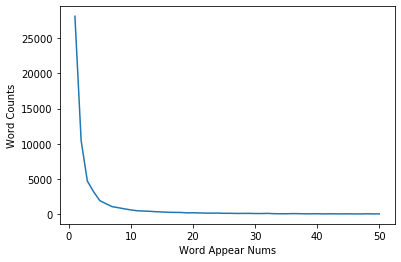

In [7]:
# TODO: 统计一下在qlist中总共出现了多少个单词？ 总共出现了多少个不同的单词(unique word)？
#       这里需要做简单的分词，对于英文我们根据空格来分词即可，其他过滤暂不考虑（只需分词）

qlist, alist = read_corpus()
word_total = [word for words_list in cut_list(qlist) for word in words_list]
word_total_old = [word for word in word_total]
word_total_unique = list(set(word_total))
# print(word_total_unique)

# TODO: 统计一下qlist中出现1次，2次，3次... 出现的单词个数， 然后画一个plot. 这里的x轴是单词出现的次数（1，2，3，..)， y轴是单词个数。
#       从左到右分别是 出现1次的单词数，出现2次的单词数，出现3次的单词数... 
# 统计词频
dict_word_count = {l:0 for l in word_total_unique}
for value in word_total:
    dict_word_count[value] +=1

#统计出现1,2,3...n的单词的个数
word_count_set = sorted(list(set(dict_word_count.values())))
dict_appear_counts = {s:0 for s in word_count_set}
for item in dict_word_count.items():
    dict_appear_counts[item[1]] += 1

x_data = list(dict_appear_counts.keys())
y_data = list(dict_appear_counts.values())

fig = plt.figure()  #设置画布
ax1 = fig.add_subplot(111)
k = 50
plt.plot(x_data[:k], y_data[:k])
ax1.set_xlabel(u'Word Appear Nums')
ax1.set_ylabel(u'Word Counts')
plt.show()

In [8]:
# TODO： 从上面的图中能观察到什么样的现象？ 这样的一个图的形状跟一个非常著名的函数形状很类似，能所出此定理吗？ 
#       hint: [XXX]'s law
# 
# 齐夫定律

In [9]:
qlist

['When did Beyonce start becoming popular?',
 'What areas did Beyonce compete in when she was growing up?',
 "When did Beyonce leave Destiny's Child and become a solo singer?",
 'In what city and state did Beyonce  grow up? ',
 'In which decade did Beyonce become famous?',
 'In what R&B group was she the lead singer?',
 'What album made her a worldwide known artist?',
 "Who managed the Destiny's Child group?",
 'When did Beyoncé rise to fame?',
 "What role did Beyoncé have in Destiny's Child?",
 'What was the first album Beyoncé released as a solo artist?',
 'When did Beyoncé release Dangerously in Love?',
 'How many Grammy awards did Beyoncé win for her first solo album?',
 "What was Beyoncé's role in Destiny's Child?",
 "What was the name of Beyoncé's first solo album?",
 'After her second solo album, what other entertainment venture did Beyonce explore?',
 'Which artist did Beyonce marry?',
 'To set the record for Grammys, how many did Beyonce win?',
 'For what movie did Beyonce rec

#### 1.3 文本预处理
此部分需要做文本方面的处理。 以下是可以用到的一些方法：

- 1. 停用词过滤 （去网上搜一下 "english stop words list"，会出现很多包含停用词库的网页，或者直接使用NLTK自带的）   
- 2. 转换成lower_case： 这是一个基本的操作   
- 3. 去掉一些无用的符号： 比如连续的感叹号！！！， 或者一些奇怪的单词。
- 4. 去掉出现频率很低的词：比如出现次数少于10,20.... （想一下如何选择阈值）
- 5. 对于数字的处理： 分词完只有有些单词可能就是数字比如44，415，把所有这些数字都看成是一个单词，这个新的单词我们可以定义为 "#number"
- 6. lemmazation： 在这里不要使用stemming， 因为stemming的结果有可能不是valid word。


In [10]:
# TODO： 需要做文本方面的处理。 从上述几个常用的方法中选择合适的方法给qlist做预处理（不一定要按照上面的顺序，不一定要全部使用）
remove_punct_map = {c:None for c in '?!@#$%^&*()~`,./|'}
low_freg_map = {value[0]:None for value in dict_word_count.items() if value[1]<3}

from nltk.corpus import stopwords
def handle_one_word(word, isuseStopWords=False, isuseLowFeqWords=False):
    # 去除low freq word
    if isuseLowFeqWords:
        if word in low_freg_map:
            return None
    # 去除标点
    word = ''.join(c for c in word if c not in remove_punct_map)
    # remove stopwords
    stop_words = stopwords.words('english')
    if isuseStopWords:
        if word in stop_words:
            return None
    
    # 处理数字
    if word.isdigit():
        word = word.replace(word, '#number')
        
    # 单词转小写
    word = word.lower()
    
def text_preparation(qlist):
    start = timeit.default_timer()
    qlist_new = []
    
    for sentence in qlist:
        sentence_new = ''
        words_list = handle_one_sentence(sentence)
        
        for word in words_list:
            word = handle_one_word(word)
            if word != None:
                sentence_new += word + ' '
        qlist_new.append(sentence_new)
    qlist = [q for q in qlist_new if q.strip()!=""]
    
    stop = timeit.default_timer()
    print('文本预处理 Time: ', stop - start)
    return qlist

qlist = text_preparation(qlist)
cut_table = cut_list(qlist, isSpecialHandle=False)
word_total = [word for words_list in cut_table for word in words_list]
word_total_unique = list(set(word_total))

文本预处理 Time:  297.44644130000006


In [11]:
print(qlist)

[]


### 第二部分： 文本的表示
当我们做完必要的文本处理之后就需要想办法表示文本了，这里有几种方式

- 1. 使用```tf-idf vector```
- 2. 使用embedding技术如```word2vec```, ```bert embedding```等

下面我们分别提取这三个特征来做对比。 

#### 2.1 使用tf-idf表示向量
把```qlist```中的每一个问题的字符串转换成```tf-idf```向量, 转换之后的结果存储在```X```矩阵里。 ``X``的大小是： ``N* D``的矩阵。 这里``N``是问题的个数（样本个数），
``D``是词典库的大小

In [135]:
# TODO 
vectorizer = TfidfVectorizer()   # 定义一个tf-idf的vectorizer

def TfidfVector():
    start = timeit.default_timer()
    X_tfidf = vectorizer.fit_transform(qlist)   # 结果存放在X矩阵
    stop = timeit.default_timer()
    print('TfidfVector_Sklean Time: ', stop - start)
    return X_tfidf

X_tfidf = TfidfVector()   # 结果存放在X矩阵里

TfidfVector_Sklean Time:  1.4428353000002971


#### 2.2 使用wordvec + average pooling
词向量方面需要下载： https://nlp.stanford.edu/projects/glove/ （请下载``glove.6B.zip``），并使用``d=200``的词向量（200维）。国外网址如果很慢，可以在百度上搜索国内服务器上的。 每个词向量获取完之后，即可以得到一个句子的向量。 我们通过``average pooling``来实现句子的向量。 

In [2]:
# TODO 基于Glove向量获取句子向量
embeddings_index = {}
glovefile = open('E:\深度学习DATASET\glove.6B\glove.6B.200d.txt', 'r', encoding='utf-8')
glove_store_path_name = "glove200_dict.pkl"

for line in glovefile:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], 'float16')
    embeddings_index[word] = coefs
    
glovefile.close()

embedding_dim_glove = 200
def get_embedding_matrix_glove(word):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        return embedding_vector[:embedding_dim_glove]
    return np.zeros(embedding_dim_glove)

word2id = {}
emd = []
for word in word_total_unique:
    if word not in word2id:
        word2id[word] = len(word2id)
        emd.append(get_embedding_matrix_glove(word))
emd = np.asarray(emd)
# 这是 D*H的矩阵，这里的D是词典库的大小， H是词向量的大小。 这里面我们给定的每个单词的词向量，
# 这需要从文本中读取

def getGetSentenceVectorCommom(sentence, embedding_dict, dim, isUseAveragePooling=False):
    total_effect_count = 0
    w_v = []
    for word in sentence:
        if word in embedding_dict:
            total_effect_count += 1
            w_v.append(embedding_dict[word])
            
    w_v = np.array(w_v)
    
    is_effect = total_effect_count > 0
    if is_effect:
        if isUseAveragePooling:
            w_v = np.sum(w_v, aixs=0) / total_effect_count
        else:
            w_v = np.max(w_v, axis=0)
    else:
        w_v = np.zeros(dim)
        
    return np.array(w_v)

X_w2v = []
for sentence in cut_table:
    w_v = GetSentenceVectorCommon(sentence, embeddings_index, embedding_dim_glove, isUseAveragePooling=True)
    X_w2v.append(w_v)

    
X_w2v = np.asarray(X_w2v)   # 初始化完emb之后就可以对每一个句子来构建句子向量了，这个过程使用average pooling来实现

#### 2.3 使用BERT + average pooling
最近流行的BERT也可以用来学出上下文相关的词向量（contex-aware embedding）， 在很多问题上得到了比较好的结果。在这里，我们不做任何的训练，而是直接使用已经训练好的BERT embedding。 具体如何训练BERT将在之后章节里体会到。 为了获取BERT-embedding，可以直接下载已经训练好的模型从而获得每一个单词的向量。可以从这里获取： https://github.com/imgarylai/bert-embedding , 请使用```bert_12_768_12```	当然，你也可以从其他source获取也没问题，只要是合理的词向量。 

In [ ]:
# TODO 基于BERT的句子向量计算
from bert_embedding import BertEmbedding
import mxnet

bert_embedding = BertEmbedding(ctx=ctx, model='bert_12_768_12')
def get_bert_embedding(qlist, isUseAveragePool = True):
    """
    功能：获取bert词向量
    :param qlist: 文本list,
    :return: 每个句子的平均bert词向量
    """
    embedding_list = []

    # qlist_new = [q.split('\n') for q in qlist]

    # all_embedding = bertEmbedding(qlist)
    # for index, item in tqdm(enumerate(all_embedding)):
    #     average_ques_embedding[index] = np.sum(item[1], axis=0) / len(item[0])
    #
    # return average_ques_embedding

    for index, question in enumerate(qlist):
        result = bertEmbedding(question.split('\n'))
        item = result[0]
        if len(item[0]) > 0:
            if isUseAveragePool:
                embedding_list.append(np.sum(np.array(item[1]), axis=0) / len(item[0]))
            else:
                embedding_list.append(np.max(np.array(item[1]), axis=0))

    return np.array(embedding_list, dtype= np.float16)

xbert_vector_s_p = "xbert_vector_new.npy"
X_bert = np.zeros(shape=(len(qlist), 768), dtype= np.float16)
if not os.path.exists(xbert_vector_s_p):
    X_bert = get_bert_embedding(qlist, False)
    np.save(xbert_vector_s_p, X_bert)
else:
    X_bert = np.load(xbert_vector_s_p)
X_bert =   # 每一个句子的向量结果存放在X_bert矩阵里。行数为句子的总个数，列数为一个句子embedding大小。 

### 第三部分： 相似度匹配以及搜索
在这部分里，我们需要把用户每一个输入跟知识库里的每一个问题做一个相似度计算，从而得出最相似的问题。但对于这个问题，时间复杂度其实很高，所以我们需要结合倒排表来获取相似度最高的问题，从而获得答案。

#### 3.1 tf-idf + 余弦相似度
我们可以直接基于计算出来的``tf-idf``向量，计算用户最新问题与库中存储的问题之间的相似度，从而选择相似度最高的问题的答案。这个方法的复杂度为``O(N)``， ``N``是库中问题的个数。

In [1]:
import heapq
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse

In [2]:
def get_least_numbers_big_data(alist, k):
    max_heapq = []
    length = len(alist)
    if not alist or k<=0 or k>length:
        return
    k -= 1
    for ele in alist:
        if len(max_heapq) <= k:
            heapq.heappush(max_heapq, ele)
        else:
            heapq.heappushpop(max_heap, ele)
    return max_heapq

In [4]:
def get_top_results_tfidf_noindex(query):
    # TODO 需要编写
    """
    给定用户输入的问题 query, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 对于用户的输入 query 首先做一系列的预处理(上面提到的方法)，然后再转换成tf-idf向量（利用上面的vectorizer)
    2. 计算跟每个库里的问题之间的相似度
    3. 找出相似度最高的top5问题的答案
    """
    
    input_seq = []
    input_vec = vectorizer.transform([input_seq])
    result = list(cosine_similarity(input_vec, X_tfidf)[0])
    top_values = sorted(get_least_numbers_big_data(result, 5), reverse=True)
    
    top_idxs = []  # top_idxs存放相似度最高的（存在qlist里的）问题的下标 
                   # hint: 请使用 priority queue来找出top results. 思考为什么可以这么做？ 
    
    len_result = len(result)
    dict_visited = {}
    for value in top_values:
        for index in range(len_result):
            if value == result[index] and index not in dict_visited:
                top_idxs.append(index)
                dict_visited[index] = True
    top_idxs = top_idxs[:5]
    
    return alist[top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案    

In [1]:
# TODO: 编写几个测试用例，并输出结果
print (get_top_results_tfidf_noindex(""))
print (get_top_results_tfidf_noindex(""))

你会发现上述的程序很慢，没错！ 是因为循环了所有库里的问题。为了优化这个过程，我们需要使用一种数据结构叫做```倒排表```。 使用倒排表我们可以把单词和出现这个单词的文档做关键。 之后假如要搜索包含某一个单词的文档，即可以非常快速的找出这些文档。 在这个QA系统上，我们首先使用倒排表来快速查找包含至少一个单词的文档，然后再进行余弦相似度的计算，即可以大大减少```时间复杂度```。

#### 3.2 倒排表的创建
倒排表的创建其实很简单，最简单的方法就是循环所有的单词一遍，然后记录每一个单词所出现的文档，然后把这些文档的ID保存成list即可。我们可以定义一个类似于```hash_map```, 比如 ``inverted_index = {}``， 然后存放包含每一个关键词的文档出现在了什么位置，也就是，通过关键词的搜索首先来判断包含这些关键词的文档（比如出现至少一个），然后对于candidates问题做相似度比较。

In [ ]:
# TODO 创建倒排表
inverted_idx = {value:[] for value in word_total_unique}  # 定一个一个简单的倒排表，是一个map结构。 循环所有qlist一遍就可以
for index, sentence in enumerate(cut_table):
    for word in sentence:
        inverted_idx[word].append(index)

#### 3.3 语义相似度
这里有一个问题还需要解决，就是语义的相似度。可以这么理解： 两个单词比如car, auto这两个单词长得不一样，但从语义上还是类似的。如果只是使用倒排表我们不能考虑到这些单词之间的相似度，这就导致如果我们搜索句子里包含了``car``, 则我们没法获取到包含auto的所有的文档。所以我们希望把这些信息也存下来。那这个问题如何解决呢？ 其实也不难，可以提前构建好相似度的关系，比如对于``car``这个单词，一开始就找好跟它意思上比较类似的单词比如top 10，这些都标记为``related words``。所以最后我们就可以创建一个保存``related words``的一个``map``. 比如调用``related_words['car']``即可以调取出跟``car``意思上相近的TOP 10的单词。 

那这个``related_words``又如何构建呢？ 在这里我们仍然使用``Glove``向量，然后计算一下俩俩的相似度（余弦相似度）。之后对于每一个词，存储跟它最相近的top 10单词，最终结果保存在``related_words``里面。 这个计算需要发生在离线，因为计算量很大，复杂度为``O(V*V)``， V是单词的总数。 

这个计算过程的代码请放在``related.py``的文件里，然后结果保存在``related_words.txt``里。 我们在使用的时候直接从文件里读取就可以了，不用再重复计算。所以在此notebook里我们就直接读取已经计算好的结果。 

In [ ]:
# TODO 读取语义相关的单词
def get_related_words(file):
    dict_related = {}
    for line in open(file, 'r', encoding='utf8'):
        item = line.split(",")
        word, si_list = item[0], [value for value in item[1].strip().split()]
        dict_related[word] = si_list
    return related_words

related_words = get_related_words('related_words.txt') # 直接放在文件夹的根目录下，不要修改此路径。

#### 3.4 利用倒排表搜索
在这里，我们使用倒排表先获得一批候选问题，然后再通过余弦相似度做精准匹配，这样一来可以节省大量的时间。搜索过程分成两步：

- 使用倒排表把候选问题全部提取出来。首先，对输入的新问题做分词等必要的预处理工作，然后对于句子里的每一个单词，从``related_words``里提取出跟它意思相近的top 10单词， 然后根据这些top词从倒排表里提取相关的文档，把所有的文档返回。 这部分可以放在下面的函数当中，也可以放在外部。
- 然后针对于这些文档做余弦相似度的计算，最后排序并选出最好的答案。


In [12]:
def get_handled_input_seq(query):
    result = []
    for word in query.split():
        word = handle_one_word(word)
        if word != None:
            result.append(word)
    return result


# 检查输入的问题并返回处理过的问题tf-idf用
def check_query(query):
    input_seq = get_handled_input_seq(query)
    result = ""
    for word in input_seq:
        result += word + " "
    return result.strip()


# 利用倒排表和同义词获取相关的预料库中问题的序号
def get_related_sentences(query):
    input_seq = get_handled_input_seq(query)
    si_list = []
    for word in input_seq:
        if word in related_words:
            for value in related_words[word]:
                si_list.append(value)

    total_list = input_seq
    for word in si_list:
        total_list.append(word)

    sentence_list = []
    for word in total_list:
        if word in inverted_idx:
            sentence_list.extend(inverted_idx[word])
    return list(set(sentence_list))

def getTopIndexByResult(result):
    top_idxs = []
    top_values = sorted(get_least_numbers_big_data(result, 5), reverse=True)
    len_result = len(result)
    dict_visited = {}
    for value in top_values:
        for index in range(len_result):
            if value == result[index] and index not in dict_visited:
                top_idxs.append(index)
                dict_visited[index] = True
    return top_idxs


In [13]:
def get_top_results_tfidf(query):
    """
    给定用户输入的问题 query, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 利用倒排表来筛选 candidate （需要使用related_words). 
    2. 对于候选文档，计算跟输入问题之间的相似度
    3. 找出相似度最高的top5问题的答案
    """
    query = check_query(query)
    if query == "":
        print_format("please input a effect question", '')
        return None
    
    sentence_list = get_related_sentences(query)
    
    top_idxs = []  # top_idxs存放相似度最高的（存在qlist里的）问题的下表 
                   # hint: 利用priority queue来找出top results. 思考为什么可以这么做?
    input_seq = query
    input_vec = vectorizer.transform([input_seq])
    
    is_use_s_l = len(sentence_list) > 0
    
    if is_use_s_l == True:
        x_tfidf_si = []
        for id in sentence_list:
            X_tfidf_si.append(X_tfidf[id].toarray()[0])
        X_tfidf_si = np.array(X_tfidf_si)
        result = list(cosine_similarity(input_vec, csr_matrix(X_tfidf_si)))
    else:
        result = list(cosine_similarity(input_vec, X_tfidf)[0])
    
    top_idxs = getTopIndexByResult(result)
    
    if is_use_s_l == True:
        top_idxs = [sentence_list[idx] for idx in top_idxsp[:5]]
    else:
        top_idxs = top_idxs[:5]
        
    return alist[top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案

In [ ]:
def get_top_results_w2v(query):
    """
    给定用户输入的问题 query, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 利用倒排表来筛选 candidate （需要使用related_words). 
    2. 对于候选文档，计算跟输入问题之间的相似度
    3. 找出相似度最高的top5问题的答案
    """
    query = check_query(query)
    if query == "":
        print_format("please input a effect question","")
        return None

    sentence_list = get_related_sentences(query)

    top_idxs = []  # top_idxs存放相似度最高的（存在qlist里的）问题的下表

    input_seq = get_handled_input_seq(query)

    g_wv = GetSentenceVectorCommon(input_seq, embeddings_index, embedding_dim_glove, isUseAveragePooling=True)

    is_use_s_l = len(sentence_list) > 0

    if is_use_s_l == True:
        X_glove_si = []
        for id in sentence_list:
            X_glove_si.append(X_w2v[id])
        X_glove_si = np.array(X_glove_si)
        result = list(cosine_similarity(csr_matrix(g_wv), csr_matrix(X_glove_si))[0])
    else:
        result = list(cosine_similarity(csr_matrix(g_wv), csr_matrix(X_w2v))[0])

    top_idxs = getTopIndexByResult(result)

    if is_use_s_l == True:
        top_idxs = [sentence_list[idx] for idx in top_idxs[:5]]
    else:
        top_idxs = top_idxs[:5]
    return alist[top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案

In [14]:
def get_top_results_bert(query):
    """
    给定用户输入的问题 query, 返回最有可能的TOP 5问题。这里面需要做到以下几点：
    1. 利用倒排表来筛选 candidate （需要使用related_words). 
    2. 对于候选文档，计算跟输入问题之间的相似度
    3. 找出相似度最高的top5问题的答案
    """
    query = check_query(query)
    if query == "":
        print_format("please input a effect question","")
        return None

    sentence_list = get_related_sentences(query)

    top_idxs = []  # top_idxs存放相似度最高的（存在qlist里的）问题的下表

    input_seq = get_handled_input_seq(query)

    # words_unique = list(set(input_seq))
    # bert_emd = {}
    # for word in words_unique:
    #     sentences = word.split('\n')
    #     result = bert_embed(sentences)
    #     first_sentence = result[0]
    #     if len(first_sentence[1]) > 0:
    #         bert_emd[word] = first_sentence[1][0]
    #
    # b_wv = GetSentenceVectorCommon(input_seq, bert_emd, embedding_dim_bert, isUseAveragePooling=False)

    seq_new = " ".join(word for word in input_seq)
    b_wv = get_bert_embedding([seq_new], False)

    is_use_s_l = len(sentence_list) > 0

    if is_use_s_l == True:
        X_bert_si = []
        for id in sentence_list:
            X_bert_si.append(X_bert[id])
        X_bert_si = np.array(X_bert_si)
        result = list(cosine_similarity(csr_matrix(b_wv), csr_matrix(X_bert_si))[0])
    else:
        result = list(cosine_similarity(csr_matrix(b_wv), csr_matrix(X_bert))[0])

    top_idxs = getTopIndexByResult(result)

    if is_use_s_l == True:
        top_idxs = [sentence_list[idx] for idx in top_idxs[:5]]
    else:
        top_idxs = top_idxs[:5]

    return alist[top_idxs]  # 返回相似度最高的问题对应的答案，作为TOP5答案

In [ ]:
# TODO: 编写几个测试用例，并输出结果

test_query1 = ""
test_query2 = ""

print (get_top_results_tfidf(test_query1))
print (get_top_results_w2v(test_query1))
print (get_top_results_bert(test_query1))

print (get_top_results_tfidf(test_query2))
print (get_top_results_w2v(test_query2))
print (get_top_results_bert(test_query2))

### 4. 拼写纠错
其实用户在输入问题的时候，不能期待他一定会输入正确，有可能输入的单词的拼写错误的。这个时候我们需要后台及时捕获拼写错误，并进行纠正，然后再通过修正之后的结果再跟库里的问题做匹配。这里我们需要实现一个简单的拼写纠错的代码，然后自动去修复错误的单词。

这里使用的拼写纠错方法，就是使用noisy channel model。 我们回想一下它的表示：

$c^* = \text{argmax}_{c\in candidates} ~~p(c|s) = \text{argmax}_{c\in candidates} ~~p(s|c)p(c)$

这里的```candidates```指的是针对于错误的单词的候选集，这部分我们可以假定是通过edit_distance来获取的（比如生成跟当前的词距离为1/2的所有的valid 单词。 valid单词可以定义为存在词典里的单词。 ```c```代表的是正确的单词， ```s```代表的是用户错误拼写的单词。 所以我们的目的是要寻找出在``candidates``里让上述概率最大的正确写法``c``。 

$p(s|c)$，这个概率我们可以通过历史数据来获得，也就是对于一个正确的单词$c$, 有百分之多少人把它写成了错误的形式1，形式2...  这部分的数据可以从``spell_errors.txt``里面找得到。但在这个文件里，我们并没有标记这个概率，所以可以使用uniform probability来表示。这个也叫做channel probability。

$p(c)$，这一项代表的是语言模型，也就是假如我们把错误的$s$，改造成了$c$， 把它加入到当前的语句之后有多通顺？在本次项目里我们使用bigram来评估这个概率。 举个例子： 假如有两个候选 $c_1, c_2$， 然后我们希望分别计算出这个语言模型的概率。 由于我们使用的是``bigram``， 我们需要计算出两个概率，分别是当前词前面和后面词的``bigram``概率。 用一个例子来表示：

给定： ``We are go to school tomorrow``， 对于这句话我们希望把中间的``go``替换成正确的形式，假如候选集里有个，分别是``going``, ``went``, 这时候我们分别对这俩计算如下的概率：
$p(going|are)p(to|going)$和 $p(went|are)p(to|went)$， 然后把这个概率当做是$p(c)$的概率。 然后再跟``channel probability``结合给出最终的概率大小。

那这里的$p(are|going)$这些bigram概率又如何计算呢？答案是训练一个语言模型！ 但训练一个语言模型需要一些文本数据，这个数据怎么找？ 在这次项目里我们会用到``nltk``自带的``reuters``的文本类数据来训练一个语言模型。当然，如果你有资源你也可以尝试其他更大的数据。最终目的就是计算出``bigram``概率。 

#### 4.1 训练一个语言模型
在这里，我们使用``nltk``自带的``reuters``数据来训练一个语言模型。 使用``add-one smoothing``

In [ ]:
from nltk.corpus import reuters
import collections

# 读取语料库的数据
categories = reuters.categories()
corpus = reuters.sents(categories=categories)

# 循环所有的语料库并构建bigram probability. bigram[word1][word2]: 在word1出现的情况下下一个是word2的概率。 
word_count_dict = collections.defaultdict(lambda: 0)
word_bigram_dict = {}
for corpu in corpus:
    for index, word in enumerate(corpu):
        word_count_dict[word] += 1
        if index >= 1:
            prev_word = corpu[index - 1]
            if prev_word not in word_bigram_dict:
                word_bigram_dict[prev_word][word] = {}
            if word not in word_bigram_dict[prev_word]:
                word_bigram_dict[prev_word][word] = 0
            word_bigram_dict[prev_word][word] += 1
        

V_words = len(word_count_dict.keys())

for key_bigram in word_bigram_dict.keys():
    for key_word in word_bigram_dict[key_bigram].keys():
        word_bigram_dict[key_bigram][key_word] = (word_bigram_dict[key_bigram][key_word] + 1) / (word_count_dict[key_bigram] + V_words) 

#### 4.2 构建Channel Probs
基于``spell_errors.txt``文件构建``channel probability``, 其中$channel[c][s]$表示正确的单词$c$被写错成$s$的概率。 

In [ ]:
# TODO 构建channel probability  
channel = {}

spell_erroe_dict = {}

for line in open('spell-errors.txt'):
    # TODO
    item = line.split(":")
    word = item[0].strip()
    spell_error_list = [word.strip() for word in item[1].strip().split(",")]
    spell_error_dict[word] = spell_error_list
# TODO

for key in spell_error_dict:
    if key not in channel:
        channel[key] = {}
        for value in spell_error_dict[key]:
            channel[key][value] = 1 / len(spell_erroe_dict[key])

print(channel)   

#### 4.3 根据错别字生成所有候选集合
给定一个错误的单词，首先生成跟这个单词距离为1或者2的所有的候选集合. 

In [ ]:
alphabet = "abcdefghijklmnopqrstuvwxyz"

def get_word_N():
    model = collections.defaultdict(lambda: 0)
    for value in word_total_old:
        model[value] += 1
    return model
words_N = get_word_N()
# print_format("len(words_unique_dict)", len(words_unique_dict))

def known(words):
    return list(set(w for w in words if w in vocab))

def edits1(word):
    n = len(word)
    #删除
    s1 = [word[0:i] + word[i+1:] for i in range(n)]
    #调换相连的两个字母
    s2 = [word[0:i] + word[i+1] + word[i] + word[i+2:] for i in range(n-1)]
    #replace
    s3 = [word[0:i] + c + word[i + 1:] for i in range(n) for c in alphabet]
    #插入
    s4 = [word[0:i] + c + word[i:] for i in range(n + 1) for c in alphabet]
    
    edit1_words = set(s1 + s2 + s3 + s4)

    if word in edit1_words:
        edit1_words.remove(word)

    edit1_words = known(edit1_words)
    
    return edit1_words

def edits2(word, edit1_words):
    edit2_words = set(e2 for e1 in edit1_words for e2 in edits1(e1))
    if word in edit2_words:
        edit2_words.remove(word)
    edit2_words = known(edit2_words)
    return edit2_words

def generate_candidates(word):
    # 基于拼写错误的单词，生成跟它的编辑距离为1或者2的单词，并通过词典库的过滤。
    # 只留写法上正确的单词。
    edit1_words = edits1(word)     # 编辑距离为1的候选项
    edit2_words = edits2(word, edit1_words)   # 编辑距离为2的候选项
    candidates = edit1_words
    for word in edit2_words:
        candidates.append(word)
    return candidates


#### 4.4 给定一个输入，如果有错误需要纠正

给定一个输入``query``, 如果这里有些单词是拼错的，就需要把它纠正过来。这部分的实现可以简单一点： 对于``query``分词，然后把分词后的每一个单词在词库里面搜一下，假设搜不到的话可以认为是拼写错误的! 人如果拼写错误了再通过``channel``和``bigram``来计算最适合的候选。

In [ ]:
import numpy as np
def getCorrectestWord(input_word, token_list, cur_index):
    candidates = generate_candidates(input_word.lower())

    if len(candidates) == 0:
        return input_word

    candidates_spell_error = []
    for candidate in candidates:
        if candidate in channel and input_word in channel[candidate]:
            candidates_spell_error.append(candidate)

    if len(candidates_spell_error) == 0:
        return max(candidates, key=lambda w: words_N[w])

    candidates = candidates_spell_error

    if(len(token_list) == 1):
        return max(candidates, key = lambda w: channel[w][input_word])

    bein_pos_state = cur_index == 0
    middle_pos_state = cur_index > 0 and  cur_index < len(token_list) - 1
    end_pos_state = cur_index == len(token_list) - 1

    prev_word = token_list[cur_index - 1] if cur_index > 0 else None
    next_word = token_list[cur_index + 1] if cur_index < len(token_list) - 1 else None

    candidates_bigram = []

    candidates_bigram_value_dic = {candidate:0 for candidate in candidates}

    for candidate in candidates:
        is_bigram_right = False
        is_bigram_left = False

        if bein_pos_state or middle_pos_state:
            if bein_pos_state:
                is_bigram_left = True
            if candidate in word_bigram_dict and next_word != None and next_word in word_bigram_dict[candidate]:
                is_bigram_right = True

        if end_pos_state or middle_pos_state:
            if end_pos_state:
                is_bigram_right = True
            if prev_word in word_bigram_dict and prev_word != None and candidate in word_bigram_dict[prev_word]:
                is_bigram_left = True
        is_bigram = is_bigram_left and is_bigram_right
        if is_bigram:
            candidates_bigram.append(candidate)
            bigram_left_prob = 1 if bein_pos_state else word_bigram_dict[prev_word][candidate]
            bigram_right_prob = 1 if end_pos_state else word_bigram_dict[candidate][next_word]
            candidates_bigram_value_dic[candidate] = bigram_left_prob * bigram_right_prob

    if len(candidates_bigram) == 0:
        return max(candidates, key=lambda w: channel[w][input_word])

    candidates = candidates_bigram

    return max(candidates, key=lambda w: channel[w][input_word] * candidates_bigram_value_dic[candidate])

def spell_corrector(line):
    # 1. 首先做分词，然后把``line``表示成``tokens``
    # 2. 循环每一token, 然后判断是否存在词库里。如果不存在就意味着是拼写错误的，需要修正。 
    #    修正的过程就使用上述提到的``noisy channel model``, 然后从而找出最好的修正之后的结果。  
    
    tokens = [word.strip() for word in line.split()]

    newline = ""
    for index, token in enumerate(tokens):
        token = handle_one_word(token, isUseLowFreg=False, isUseStopWord=False)
        if token == None or token.strip() == "":
            continue
        if token.lower() not in vocab: #默认单词拼错了
            token = getCorrectestWord(token, tokens, index)
        newline += token + " "
    return newline

#### 4.5 基于拼写纠错算法，实现用户输入自动矫正
首先有了用户的输入``query``， 然后做必要的处理把句子转换成tokens的形状，然后对于每一个token比较是否是valid, 如果不是的话就进行下面的修正过程。 

In [ ]:
test_query1 = ""  # 拼写错误的
test_query2 = ""  # 拼写错误的

test_query1 = spell_corector(test_query1)
test_query2 = spell_corector(test_query2)

print (get_top_results_tfidf(test_query1))
print (get_top_results_w2v(test_query1))
print (get_top_results_bert(test_query1))

print (get_top_results_tfidf(test_query2))
print (get_top_results_w2v(test_query2))
print (get_top_results_bert(test_query2))

### 附录 
在本次项目中我们实现了一个简易的问答系统。基于这个项目，我们其实可以有很多方面的延伸。
- 在这里，我们使用文本向量之间的余弦相似度作为了一个标准。但实际上，我们也可以基于基于包含关键词的情况来给一定的权重。比如一个单词跟related word有多相似，越相似就意味着相似度更高，权重也会更大。 
- 另外 ，除了根据词向量去寻找``related words``也可以提前定义好同义词库，但这个需要大量的人力成本。 
- 在这里，我们直接返回了问题的答案。 但在理想情况下，我们还是希望通过问题的种类来返回最合适的答案。 比如一个用户问：“明天北京的天气是多少？”， 那这个问题的答案其实是一个具体的温度（其实也叫做实体），所以需要在答案的基础上做进一步的抽取。这项技术其实是跟信息抽取相关的。 
- 对于词向量，我们只是使用了``average pooling``， 除了average pooling，我们也还有其他的经典的方法直接去学出一个句子的向量。
- 短文的相似度分析一直是业界和学术界一个具有挑战性的问题。在这里我们使用尽可能多的同义词来提升系统的性能。但除了这种简单的方法，可以尝试其他的方法比如WMD，或者适当结合parsing相关的知识点。 